In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import feature_manager as fma
import rl.env_simple_crypto_trade as env
import importlib
import rl.models as rla
import config as cf
import numpy as np
from torch.nn import Tanh
import tr_utils
import wandb

In [ ]:
wandb.finish(0)

## Prepare data and envirnoment

In [ ]:
importlib.reload(fma)

fm = fma.FeatureManager()
fm.import_data(symbol="BTCUSDT",timeframes=["1d","1w","1mo"])

fm.build_features(
    lags = [5,3,1],
    features=cf.FOR_1D_INDICATORS,
)

In [ ]:
%store fm

In [ ]:
%store -r fm 

In [ ]:
fm

In [ ]:
importlib.reload(env)
importlib.reload(cf)

env_kwargs = cf.TRADE_ENV_PARAMETER
state_space = 10 + len(fm.cols)

full_env = env.CryptoTradingEnv(
    trade_timeframe="1d",
    df = fm.df, 
    state_space=state_space,
    indicators=fm.cols,
    **env_kwargs)

## Setup agent and model

In [ ]:
importlib.reload(rla)
agent = rla.DRLTradeAgent(env=full_env)

PPO_MODEL_PARAMS = {
    "gamma": 0.9995,
    "gae_lambda": 0.95,
    "n_steps": 1536,
    "ent_coef": 0.001,
    "learning_rate": 0.00015,
    "batch_size": 64
}

PPO_POLICY_PARAMS = {
    "activation_fn":Tanh,
    "net_arch": dict(pi=[128,256,256,128], vf=[128,256,256,128])
}

wandb.init(
    name="ppo-try-17",
    config=PPO_MODEL_PARAMS
)

catalog_name = tr_utils.get_name_with_kwargs("encourage_short_1d_custom_ppo",PPO_MODEL_PARAMS,excludes=[])

model = agent.get_model(
    model_name="c_ppo",
    model_kwargs = PPO_MODEL_PARAMS,
    policy_kwargs= PPO_POLICY_PARAMS,
    tensorboard_log=catalog_name,
    seed = 100
)

## Train model

In [ ]:
model = agent.train_model(
    model = model,
    total_timesteps = 1_000_000,
    checkpoint = True,
    catalog_name = catalog_name,
    save_frequency = 30_000,
    progress_bar = True
)

## Load checkpoint saved model


In [ ]:
catalog =  "new_rwd_1d_custom_ppo_gamma_0.995_gae_lambda_0.95_n_steps_1536_ent_coef_0.03_learning_rate_0.0001_batch_size_64_use_sde_False"
filename = catalog + "/rl_model_1000000_steps"
model = agent.load_model_from_checkpoint("c_ppo",filename)

In [ ]:

PPO_MODEL_PARAMS = {
    "gamma": 0.999,
    "gae_lambda": 0.95,
    "n_steps": 1536,
    "ent_coef": 0.05,
    "learning_rate": 0.0002,
    "batch_size": 64
}

wandb.init(
    name="ppo-try-9",
    config=PPO_MODEL_PARAMS
)


In [1]:
%store -r fm

In [2]:
fm

<AxesSubplot: xlabel='Open Time'>

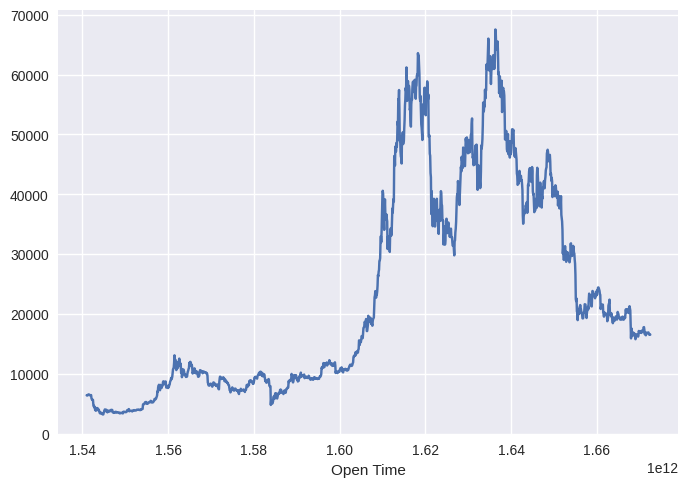

In [3]:
fm.df["Close"].plot()

In [96]:
sma = (fm.df['sma_3_10_level1_lag_1']/fm.df["Close"])

In [103]:
n_sma = 2*(sma - sma.min())/(sma.max()-sma.min())-1